In [1]:
import os
import yaml
import sys
sys.path.append("/home/sid/workspace/LIDAR-Based-3D-Object-Detection/")
os.chdir("/home/sid/workspace/LIDAR-Based-3D-Object-Detection/")

In [2]:
ARTIFACTS_FOLDER = "./playground/artifacts"

In [3]:
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

In [4]:
level5data = LyftDataset(data_path='.', json_path='/mnt/e/LFS/3d-object-detection-for-autonomous-vehicles/train_data', verbose=True)
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)

OSError: [Errno 5] Input/output error: '/mnt/e/LFS/3d-object-detection-for-autonomous-vehicles/train_data/category.json'

In [5]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]

In [6]:
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in level5data.scene]
sorted(records)

entries = []

for start_time, record in sorted(records):
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000

    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))
            
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])
df.head()

,host,scene_name,date,scene_token,first_sample_token
0,host-a007,host-a007-lidar0-1230485630199365106-123048565...,2019-01-02 17:33:50.301987,473093b48a7cb78d05e36245fd2dbd12d66ded7dab1ecb...,c7f7de87ec90c8993d4e7d5463208d2aa9f5ecde671960...
1,host-a007,host-a007-lidar0-1230672860198383106-123067288...,2019-01-04 21:34:20.301189,c62b89d6ae60528c00b8a520bfa16799147f5c2dccbe1e...,07889e50d51717e829cbcb4800e6cb2ce08bdabe92440c...
2,host-a007,host-a007-lidar0-1230936221299185986-123093624...,2019-01-07 22:43:41.402021,694dc7b4629151745d3e1b228b1d6653b0fc1ded12aa8d...,83ce1da2c4b37ca88a102928f01512acf8f55ac7207d04...
3,host-a007,host-a007-lidar0-1231093036199514746-123109306...,2019-01-09 18:17:16.302257,8ed3a2f8cf6e01e0d2c0df7db77839f468ed2aa48b6511...,dddda3940f002b0fa6c495a5ad6d5c4a4c8253aa5ed189...
4,host-a009,host-a009-lidar0-1231200854198312986-123120087...,2019-01-11 00:14:14.301261,a05a48966fbc46666be116a79222374c6c79e6fa930c2f...,8990abea0a146b047a04bc6ed303b16cb1c62cca49bf58...


In [7]:
host_count_df = df.groupby("host")['scene_token'].count()
print(host_count_df)
sum(host_count_df)

host
host-a004    42
host-a005     1
host-a006     3
host-a007    26
host-a008     5
host-a009     9
host-a011    51
host-a012     2
host-a015     6
host-a017     3
host-a101    20
host-a102    12
Name: scene_token, dtype: int64


180

In [8]:
validation_hosts = ["host-a007", "host-a008", "host-a009"]
validation_df = df[df["host"].isin(validation_hosts)]
vi = validation_df.index
train_df = df[~df.index.isin(vi)]

print(len(train_df), len(validation_df), "train/validation split scene counts")
print(vi)

140 40 train/validation split scene counts
Int64Index([  0,   1,   2,   3,   4,   8,  10,  14,  40,  44,  55,  56,  57,
             59,  60,  63,  65,  72,  77,  80,  82,  83,  85,  87, 100, 103,
            104, 107, 108, 117, 118, 119, 120, 121, 122, 124, 136, 137, 144,
            147],
           dtype='int64')


In [9]:
train_df.head()

,host,scene_name,date,scene_token,first_sample_token
5,host-a005,host-a005-lidar0-1231201437298603426-123120146...,2019-01-11 00:23:57.401682,41bdc6cc36d768bb74315128a329e7c6554bd2a6ad6bfc...,cea0bba4b425537cca52b17bf81569a20da1ca6d359f33...
6,host-a011,host-a011-lidar0-1232401360198078026-123240138...,2019-01-24 21:42:40.301065,2bd00da3465bac6fdfe2177a12118650679e84e3133b2d...,2d96b2588f8c4ae81c94ceeda42b3b03e977dfff190c52...
7,host-a011,host-a011-lidar0-1232412236198491106-123241226...,2019-01-25 00:43:56.301489,d9161aaeef7bab4d1ceb5deb7365ac4627914eacfc88e2...,d31cbe171e3d54da81df2345ac7af6167f5df2623cb0c3...
9,host-a011,host-a011-lidar0-1232485958298280666-123248598...,2019-01-25 21:12:38.401113,f40b928370a9cc88971da97f0c235b41aea6fe928ea25f...,66308cdc803d44d9733167a9bf58a1a1f8e2652fb049d8...
11,host-a011,host-a011-lidar0-1232492192198952026-123249221...,2019-01-25 22:56:32.301720,cff25ea9f04a36e8f395e23e3cfcfa73bfe93600c28724...,3a9c27b30485c30d98a6c0d5a6f1ea2857aa932a2757e0...


In [10]:
sample_token = train_df.first_sample_token.values[0]
sample = level5data.get("sample", sample_token)

sample_lidar_token = sample["data"]["LIDAR_TOP"]
lidar_data = level5data.get("sample_data", sample_lidar_token)
lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
print(lidar_filepath)
print(lidar_data)

ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])

print("Ego Pose:", ego_pose)
print("calibrated_sensor", calibrated_sensor)

# Homogeneous transformation matrix from car frame to world frame.
global_from_car = transform_matrix(ego_pose['translation'],
                                   Quaternion(ego_pose['rotation']), inverse=False)

# Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                    inverse=False)

/home/sid/workspace/LIDAR-Based-3D-Object-Detection/lidar/host-a005_lidar1_1231201437401681856.bin
{'is_key_frame': True, 'prev': '', 'fileformat': 'bin', 'ego_pose_token': 'ad84a94d701323a49fd890e31553c3a60405e9428b84749c9f3f85226829fbcd', 'timestamp': 1547166237401681.8, 'next': 'b1e97f7040470a2171ed110bfe0e0d5dfe7a6b5ed92ed53e8d14ecb4140dd298', 'token': '5d6d78ab8d58702d82284d89c164311b79dbf131be93f477f0cb2fcfe673ba74', 'sample_token': 'cea0bba4b425537cca52b17bf81569a20da1ca6d359f33227f0230d59d9d2881', 'filename': 'lidar/host-a005_lidar1_1231201437401681856.bin', 'calibrated_sensor_token': 'c87689b89f1bfa3e3b964be42bf25bd27298f90696d4da851aacb2a51db68acf', 'sensor_modality': 'lidar', 'channel': 'LIDAR_TOP'}
Ego Pose: {'rotation': [0.16443143502531854, 0.02522225267574294, 0.0117456840556274, 0.9859960345009208], 'translation': [871.9098767426335, 2567.7695447600618, -21.791296281900813], 'token': 'ad84a94d701323a49fd890e31553c3a60405e9428b84749c9f3f85226829fbcd', 'timestamp': 154716

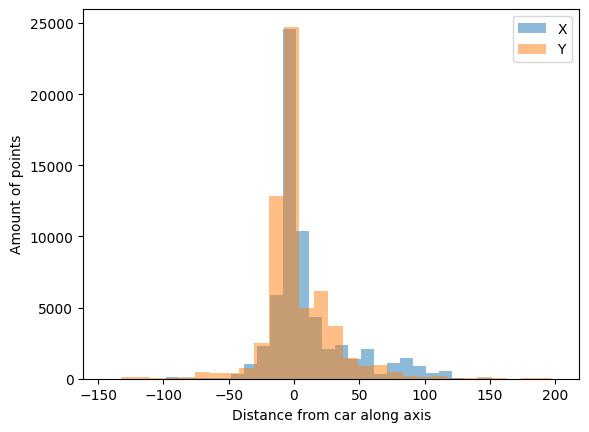

In [11]:
lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
print(lidar_pointcloud)

# The lidar pointcloud is defined in the sensor's reference frame.
# We want it in the car's reference frame, so we transform each point
lidar_pointcloud.transform(car_from_sensor)

# A sanity check, the points should be centered around 0 in car space.
plt.hist(lidar_pointcloud.points[0], alpha=0.5, bins=30, label="X")
plt.hist(lidar_pointcloud.points[1], alpha=0.5, bins=30, label="Y")
plt.legend()
plt.xlabel("Distance from car along axis")
plt.ylabel("Amount of points")
plt.show()

In [12]:
print(lidar_pointcloud.points.shape)
print(lidar_pointcloud.points)


(4, 61908)
[[-97.33626    -95.891556   -95.581436   ...  -4.3027453   -4.3097425
   -4.308989  ]
 [  8.948838     9.516727    10.167154   ...   0.17457172   0.19416472
    0.21448715]
 [ 11.900117    11.759933    11.736123   ...   0.15442245   0.15207818
    0.15207745]
 [100.         100.         100.         ... 100.         100.
  100.        ]]


In [13]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))
    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]

# Let's try it with some example values
tm = create_transformation_matrix_to_voxel_space(shape=(100,100,4), voxel_size=(0.5,0.5,0.5), offset=(0,0,0.5))
p = transform_points(np.array([[10, 10, 0, 0, 0], [10, 5, 0, 0, 0],[0, 0, 0, 2, 0]], dtype=np.float32), tm)
print(p)

[[70. 70. 50. 50. 50.]
 [70. 60. 50. 50. 50.]
 [ 3.  3.  3.  7.  3.]]


In [14]:
def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)


voxel_size = (0.4,0.4,1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)

# So that the values in the voxels range from 0,1 we set a maximum intensity.
bev = normalize_voxel_intensities(bev)

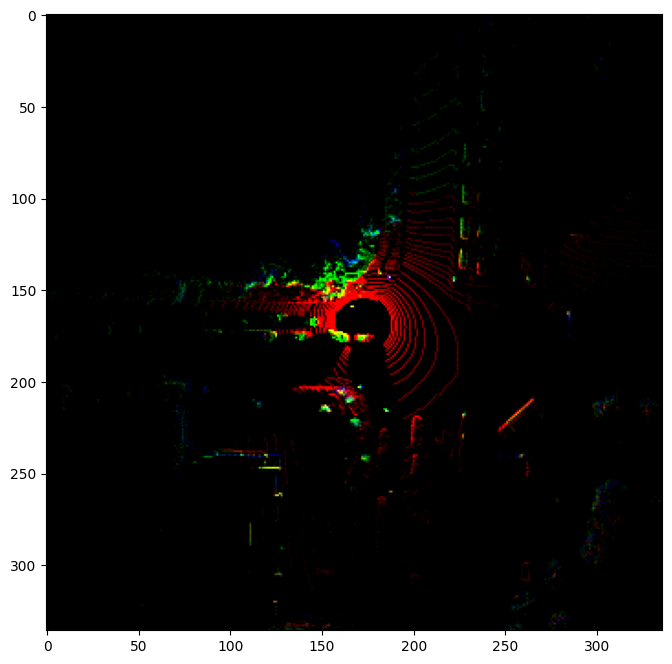

In [15]:
plt.figure(figsize=(16,8))
plt.imshow(bev)
plt.show()

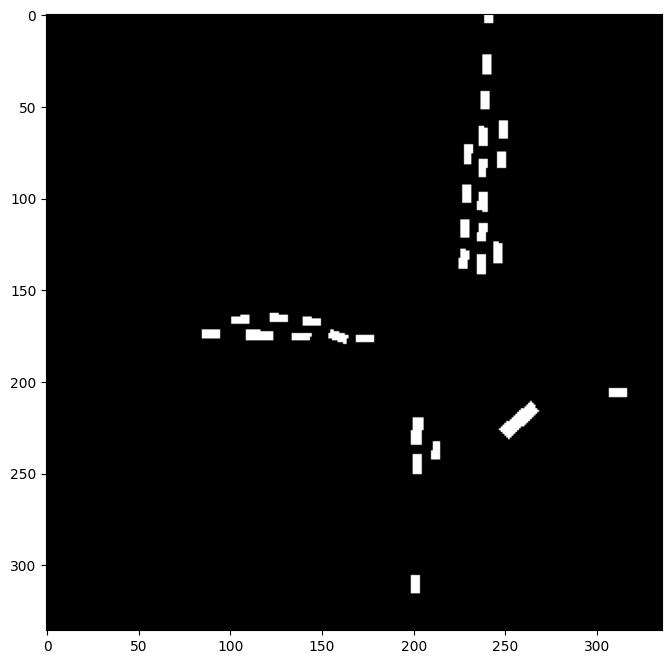

In [16]:
boxes = level5data.get_boxes(sample_lidar_token)

target_im = np.zeros(bev.shape[:3], dtype=np.uint8)

def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)



move_boxes_to_car_space(boxes, ego_pose)
scale_boxes(boxes, 0.8)
draw_boxes(target_im, voxel_size, boxes, classes, z_offset=z_offset)

plt.figure(figsize=(8,8))
plt.imshow((target_im > 0).astype(np.float32), cmap='Set2')
plt.show()

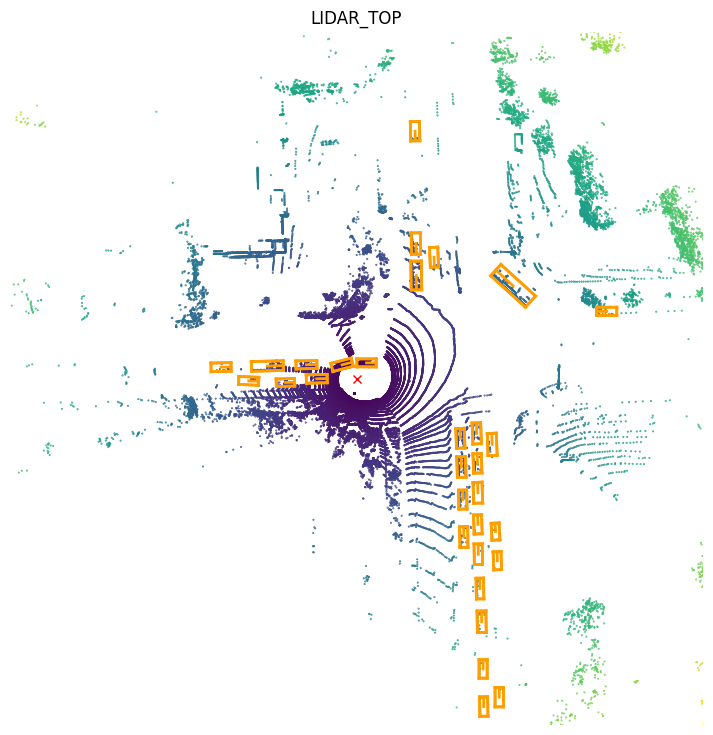

In [17]:
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
    
# Don't worry about it being mirrored.
visualize_lidar_of_sample(sample_token)

In [18]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

In [19]:
# "bev" stands for birds eye view
train_data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_train_data")
validation_data_folder = os.path.join(ARTIFACTS_FOLDER, "./bev_validation_data")

In [23]:
NUM_WORKERS =  1

def prepare_training_data_for_scene(first_sample_token, output_folder, bev_shape, voxel_size, z_offset, box_scale):
    """
    Given a first sample token (in a scene), output rasterized input volumes and targets in birds-eye-view perspective.

    """
    sample_token = first_sample_token
    
    while sample_token:
        
        sample = level5data.get("sample", sample_token)

        sample_lidar_token = sample["data"]["LIDAR_TOP"]
        lidar_data = level5data.get("sample_data", sample_lidar_token)
        lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

        ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])


        global_from_car = transform_matrix(ego_pose['translation'],
                                           Quaternion(ego_pose['rotation']), inverse=False)

        car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                            inverse=False)

        try:
            lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
            lidar_pointcloud.transform(car_from_sensor)
        except Exception as e:
            print ("Failed to load Lidar Pointcloud for {}: {}:".format(sample_token, e))
            sample_token = sample["next"]
            continue
        
        bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        bev = normalize_voxel_intensities(bev)

        
        boxes = level5data.get_boxes(sample_lidar_token)

        target = np.zeros_like(bev)

        move_boxes_to_car_space(boxes, ego_pose)
        scale_boxes(boxes, box_scale)
        draw_boxes(target, voxel_size, boxes=boxes, classes=classes, z_offset=z_offset)

        bev_im = np.round(bev*255).astype(np.uint8)
        target_im = target[:,:,0] # take one channel only

        cv2.imwrite(os.path.join(output_folder, "{}_input.png".format(sample_token)), bev_im)
        cv2.imwrite(os.path.join(output_folder, "{}_target.png".format(sample_token)), target_im)
        
        sample_token = sample["next"]

for df, data_folder in [(train_df, train_data_folder), (validation_df, validation_data_folder)]:
    print("Preparing data into {} using {} workers".format(data_folder, NUM_WORKERS))
    first_samples = df.first_sample_token.values

    os.makedirs(data_folder, exist_ok=True)
    
    process_func = partial(prepare_training_data_for_scene,
                           output_folder=data_folder, bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale)

    pool = Pool(NUM_WORKERS)
    for _ in tqdm(pool.imap_unordered(process_func, first_samples), total=len(first_samples)):
        pass
    pool.close()
    del pool

Preparing data into ./playground/artifacts/bev_train_data using 20 workers


Failed to load Lidar Pointcloud for d31cbe171e3d54da81df2345ac7af6167f5df2623cb0c3cd2b2666506cba2e70: [Errno 12] Cannot allocate memory: '/home/sid/workspace/LIDAR-Based-3D-Object-Detection/lidar/host-a011_lidar1_1232412236301489166.bin':Failed to load Lidar Pointcloud for 9eca1614e26d608e217505637dd6af384d4317175569e35b002c9dea60ec83d2: [Errno 12] Cannot allocate memory: '/home/sid/workspace/LIDAR-Based-3D-Object-Detection/lidar/host-a011_lidar1_1232732468402211046.bin':

Failed to load Lidar Pointcloud for 617d56e9f6d9c8ace3fd7bf32beb2e958221ae3fc3fc30b6aadcaf02807d8359: [Errno 12] Cannot allocate memory: '/home/sid/workspace/LIDAR-Based-3D-Object-Detection/lidar/host-a011_lidar1_1232752543300829726.bin':Failed to load Lidar Pointcloud for debd736d5102aed9012c7680c02d0121a1d808233b4c70f7a34addab6020468b: [Errno 12] Cannot allocate memory: '/home/sid/workspace/LIDAR-Based-3D-Object-Detection/lidar/host-a011_lidar1_1232745770302014726.bin':

Failed to load Lidar Pointcloud for 3c68f729

: 

: 

In [21]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 735.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 5.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.3/384.3 kB 13.5 MB/s eta 0:00:00
